In [5]:
import pyodbc
import pandas as pd
import numpy as np
import sqlalchemy as sa
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import norm, binom
import statsmodels.api as sm
from sklearn.model_selection import (train_test_split, GridSearchCV)
from sklearn.linear_model import LogisticRegression
from statsmodels.tools.tools import add_constant
import json
import yaml
import xgboost as xgb
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    make_scorer
)
with open('../risk/auth/db_auth.yaml', 'r') as stream:
    config = yaml.safe_load(stream)
    connstring = f"DRIVER={{{config['driver']}}};SERVER={config['server']};DATABASE={config['database']};UID={config['username']};PWD={config['password']};Encrypt=YES;TrustServerCertificate=YES"


In [6]:
def get_model_scores(model, x, y, title):
    """
    Function to get scores for classification models.
    :param model: classification model
    :param x: endogenous (independent) features
    :param y: exogenous (dependent) feature
    :threshold: Threshold above which the observation is classified as 1
    :returns: Pandas DataFrame with scores
    """
    pred = np.round(model.predict(x))
    df_performance = pd.DataFrame(
        {   'Title': title,
            'Accuracy': accuracy_score(y, pred),
            'Recall': recall_score(y, pred),
            'Precision': precision_score(y, pred),
            'F1 Score': f1_score(y, pred)
        },
        index=[0]
    )
    return df_performance

In [7]:
def make_confusion_matrix(model, x, y, labels=[1, 0], threshold=.5):
    """
    Create confusion matrix with labels for true / false and pos / neg
    :param model: statistical model to create confusion matrix on
    :param x: endogenous variables of model. Used to create predictions,
              which in turn are used to compare against y in creating the matrix
    :param y: exogenous variable to compare against predicted y vals
    :returns: Seaborn Heatmap 
    """
    # Make predictions using model
    y_pred = model.predict(x) > threshold
    # get confustion matrix values
    conf_matrix = confusion_matrix(y, y_pred, labels=[0, 1])
    # Convert confusion matrix to dataframe
    df_cm = pd.DataFrame(
        data=conf_matrix,
        index = [ i for i in ['Actual - No', 'Actual - Yes']],
        columns = [i for i in ['Predicted - No', 'Predicted - Yes']]
    )
    # Set group names for True / False and Pos / Neg
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    # Count values in each group
    group_counts = ['{0:0.0f}'.format(value) for value in conf_matrix.flatten()]
    # Calculate pct of total each group represents
    group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
    # Convert group names etc into lables for chart
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    # reshape the label array for sns.heatmap
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    # Create heatmap
    sns.heatmap(
        data=df_cm,
        annot=labels,
        fmt='',
        cmap='Blues'
    )
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')

In [8]:
def get_class_model_scores(model, x, y, threshold = .5):
    """
    Function to get scores for classification models.
    :param model: classification model
    :param x: endogenous (independent) features
    :param y: exogenous (dependent) feature
    :threshold: Threshold above which the observation is classified as 1
    :returns: Pandas DataFrame with scores
    """
    pred = np.round(model.predict(x) > threshold)
    df_performance = pd.DataFrame(
        {
            'Accuracy': accuracy_score(y, pred),
            'Recall': recall_score(y, pred),
            'Precision': precision_score(y, pred),
            'F1 Score': f1_score(y, pred)
        },
        index=[0]
    )
    return df_performance

In [9]:
query = """
        SELECT [sg].[atk_strength],
               [sg].[def_strength],
               [sg].[atk_losses],
               [sg].[def_losses],
               [sg].[outcome]
          FROM sim.sim_games sg;
        """

In [10]:
with pyodbc.connect(connstring) as conn:
    cur = conn.cursor()
    # cur.execute('SELECT @@version')
    # print(cur.fetchone())
    cur.execute(query)
    df = pd.DataFrame.from_records(
        cur.fetchall(),
        columns=[col[0] for col in cur.description],
    )
    cur.close()

df

,atk_strength,def_strength,atk_losses,def_losses,outcome
0,1,1,0,1,True
1,1,1,1,0,False
2,1,1,0,1,True
3,1,1,1,0,False
4,1,1,0,1,True
...,...,...,...,...,...
8999995,30,30,30,23,False
8999996,30,30,30,29,False
8999997,30,30,13,30,True
8999998,30,30,18,30,True


In [11]:
df['outcome'] = df['outcome'].astype(np.float64)

x = df[['atk_strength', 'def_strength']].copy()
outcome = df['outcome'].copy()
atk_losses = df['atk_losses'].copy()
def_losses = df['def_losses'].copy()
del df

In [12]:
# x = add_constant(x)
x_train, x_test, outcome_train, outcome_test = train_test_split(
    x,
    outcome,
    test_size=.3,
    stratify=outcome
)


In [9]:
model = sm.Logit(outcome_train, x_train).fit()

Optimization terminated successfully.
         Current function value: 0.289746
         Iterations 8


In [10]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                outcome   No. Observations:              6300000
Model:                          Logit   Df Residuals:                  6299998
Method:                           MLE   Df Model:                            1
Date:                Sat, 03 Sep 2022   Pseudo R-squ.:                  0.5798
Time:                        16:30:20   Log-Likelihood:            -1.8254e+06
converged:                       True   LL-Null:                   -4.3438e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
atk_strength     0.3242      0.000   1201.023      0.000       0.324       0.325
def_strength    -0.2917      0.000  -1172.278      0.000      -0.292      -0.291
================================================================================
"""

In [11]:
outcome_pred_train = model.predict(x_train) > .5
outcome_pred_train = np.round(outcome_pred_train)

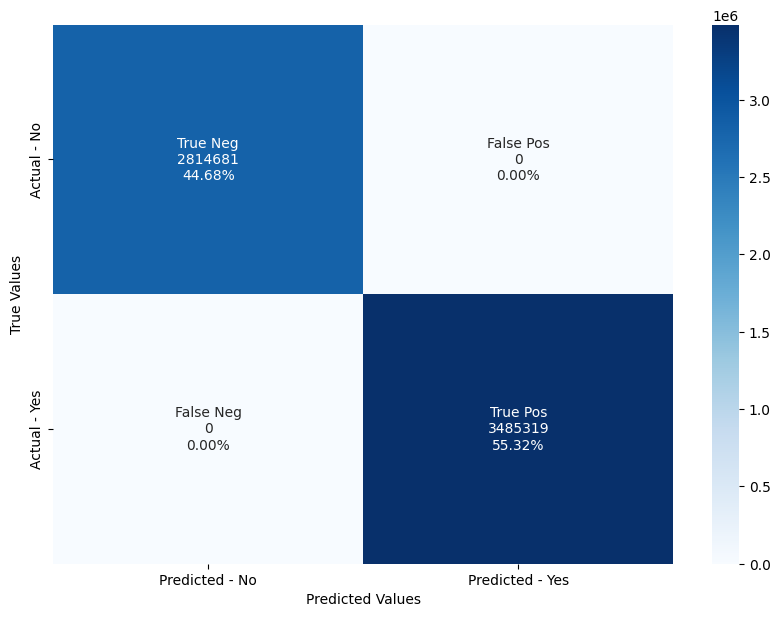

In [12]:
make_confusion_matrix(
    model=model,
    x=x_train,
    y=outcome_pred_train
)

In [13]:
odds = np.exp(model.params)
pd.DataFrame(odds, x_train.columns, columns=['odds']).T

,atk_strength,def_strength
odds,1.3829,0.747012


In [14]:
perc_change_odds = (np.exp(model.params) -1 ) * 100

pd.DataFrame(perc_change_odds, x_train.columns, columns=['change_odds%']).T

,atk_strength,def_strength
change_odds%,38.290002,-25.298792


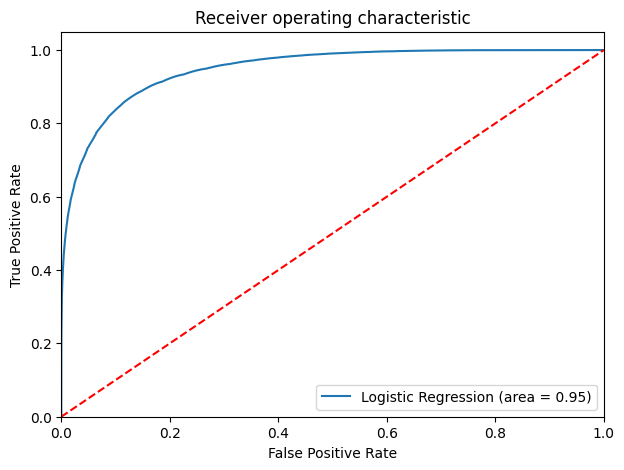

In [15]:
logit_roc_auc_train = roc_auc_score(
    y_true=outcome_train,
    y_score=model.predict(x_train)
)
fpr, tpr, thresholds = roc_curve(
    y_true=outcome_train,
    y_score=model.predict(x_train)
)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % logit_roc_auc_train)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

In [16]:
outcome_pred_test = model.predict(x_test) > .5
outcome_pred_test = np.round(outcome_pred_test)

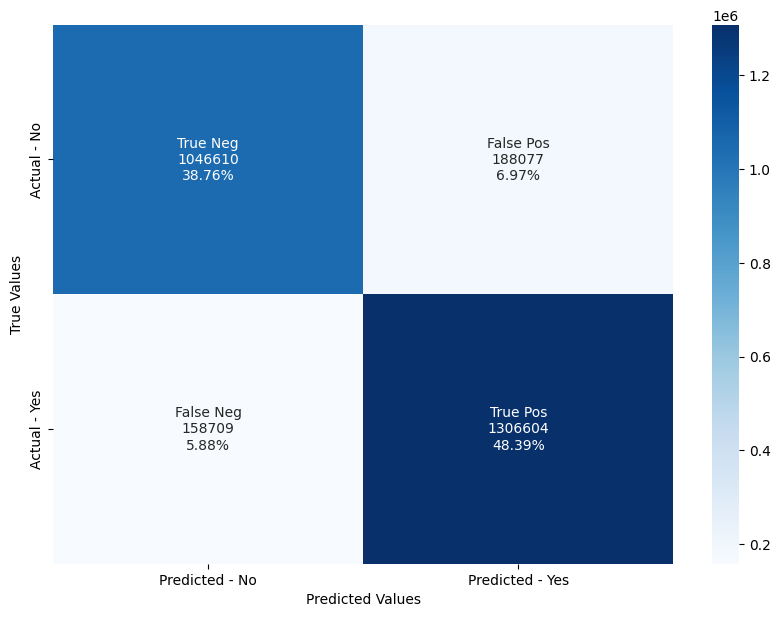

In [17]:
make_confusion_matrix(
    model=model,
    x=x_test,
    y=outcome_test
)

In [18]:
outcome_optimal_index = np.argmax(tpr - fpr)
outcome_optimal_threshold_roc_auc = thresholds[outcome_optimal_index]
print(outcome_optimal_threshold_roc_auc)

0.5488334551222288


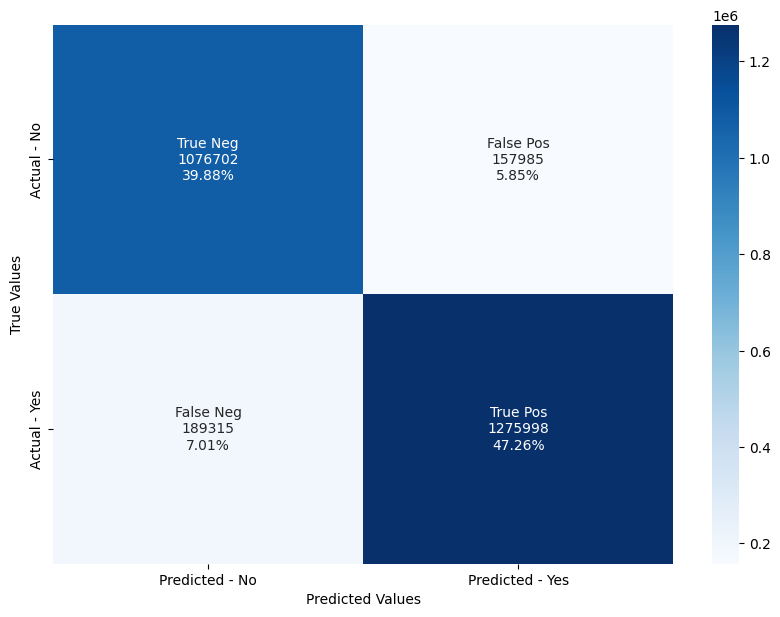

In [19]:
make_confusion_matrix(
    model=model,
    x=x_test,
    y=outcome_test,
    threshold=outcome_optimal_threshold_roc_auc
)

In [20]:
get_class_model_scores(
    model=model,
    x=x_test,
    y=outcome_test,
    threshold=outcome_optimal_threshold_roc_auc
)

,Accuracy,Recall,Precision,F1 Score
0,0.87137,0.870802,0.889828,0.880212


In [21]:
get_class_model_scores(
    model=model,
    x=x_test,
    y=outcome_test
)

,Accuracy,Recall,Precision,F1 Score
0,0.871561,0.891689,0.874169,0.882842


In [22]:
atk_str = 3
def_str = 4
prediction = model.predict(
    pd.DataFrame(
        {
            #'const': 1.0,
            'atk_strength': atk_str,
            'def_strength': def_str
        },
        index=[0]
    )
)

prediction

0    0.451615
dtype: float64

In [23]:
atk_str = 5
def_str = 5
prediction = model.predict(
    pd.DataFrame(
        {
            #'const': 1.0,
            'atk_strength': atk_str,
            'def_strength': def_str
        },
        index=[0]
    )
)

prediction

0    0.540547
dtype: float64

In [24]:
import xgboost as xgb

train = xgb.DMatrix(x_train, outcome_train)
test = xgb.DMatrix(x_test, outcome_test)

xgbclass_1 = xgb.XGBClassifier(
    eval_metric='auc'
)

xgbclass_1.fit(
    x_train,
    outcome_train,
    eval_set=[(x_train, outcome_train), (x_test, outcome_test)]
)
print(xgbclass_1.get_params())

[0]	validation_0-auc:0.94867	validation_1-auc:0.94855
[1]	validation_0-auc:0.95035	validation_1-auc:0.95022
[2]	validation_0-auc:0.95102	validation_1-auc:0.95089
[3]	validation_0-auc:0.95125	validation_1-auc:0.95112
[4]	validation_0-auc:0.95138	validation_1-auc:0.95126
[5]	validation_0-auc:0.95145	validation_1-auc:0.95132
[6]	validation_0-auc:0.95150	validation_1-auc:0.95137
[7]	validation_0-auc:0.95154	validation_1-auc:0.95142
[8]	validation_0-auc:0.95157	validation_1-auc:0.95144
[9]	validation_0-auc:0.95159	validation_1-auc:0.95146
[10]	validation_0-auc:0.95161	validation_1-auc:0.95148
[11]	validation_0-auc:0.95162	validation_1-auc:0.95148
[12]	validation_0-auc:0.95162	validation_1-auc:0.95149
[13]	validation_0-auc:0.95163	validation_1-auc:0.95150
[14]	validation_0-auc:0.95164	validation_1-auc:0.95150
[15]	validation_0-auc:0.95164	validation_1-auc:0.95150
[16]	validation_0-auc:0.95165	validation_1-auc:0.95151
[17]	validation_0-auc:0.95165	validation_1-auc:0.95151
[18]	validation_0-au

In [25]:
# import hyperopt
# from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
# 
# # space = {
# #     'max_depth': hp.quniform('max_depth', 3, 18, 1),
# #     'gamma': hp.uniform('gamma', 1, 9),
# #     'reg_alpha': hp.quniform('reg_alpha', 40, 180, 1),
# #     'reg_lambda': hp.uniform('reg_lambda', 0, 1),
# #     'colsample_bytree': hp.uniform('colsample_bytree', .5, 1),
# #     'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
# #     'scale_pos_weight': hp.quniform('scale_pos_weight', 1,4,1),
# #     # 'subsample': hp.uniform('subsample', .5, 1, .1),
# #     # 'eval_metric': hp.choice('eval_metric', ['logloss', 'auc', 'aucpr']),
# #     'n_estimators': 100
# # }
# 
# space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
#         'gamma': hp.uniform ('gamma', 1,9),
#         'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
#         'reg_lambda' : hp.uniform('reg_lambda', 0,1),
#         'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
#         'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
#         # 'eval_metric': hp.choice('eval_metric', ['logloss', 'auc', 'rmse']),
#         'eval_metric': 'auc',
#         'objective': 'binary:logistic',
#         'booster': 'gbtree',
#         'n_estimators': 180
#     }
# # Classifier:
# def hyperparameter_tuning(space):
#     model = xgb.XGBClassifier(
#         n_estimators =space['n_estimators'],
#         max_depth = int(space['max_depth']),
#         gamma = space['gamma'],
#         reg_alpha = int(space['reg_alpha']),
#         min_child_weight=space['min_child_weight'],
#         colsample_bytree=space['colsample_bytree'],
#         eval_metric=space['eval_metric'],
#         early_stopping_rounds=10
#     )
#     evaluation = [( x_train, outcome_train), ( x_test, outcome_test)]
#     
#     model.fit(
#         x_train,
#         outcome_train,
#         eval_set=evaluation,
#         # eval_metric="auc",
#         # early_stopping_rounds=10,
#         verbose=False)
# 
#     pred = model.predict(x_test)
#     # roc_auc = roc_auc_score(outcome_test, pred)
#     accuracy = accuracy_score(outcome_test, pred>.5)
#     print ("SCORE:", accuracy)
#     #change the metric if you like
#     return {'loss': -accuracy, 'status': STATUS_OK, 'model': model}
# trials = Trials()
# best_hyperparams = fmin(fn=hyperparameter_tuning,
#             space=space,
#             algo=tpe.suggest,
#             max_evals=100,
#             trials=trials)
# 
# print(best_hyperparams)
# import json
# with open('xg_tuned_params.json', 'w') as outfile:
#     json.dump(best_hyperparams, outfile, indent=4)

In [14]:
evaluation = [(x_train, outcome_train), (x_test, outcome_test)]
params = json.load(open('./xg_tuned_params.json'))
xgbclass_tuned = xgb.XGBClassifier(**params)
xgbclass_tuned.fit(
    x_train,
    outcome_train,
    eval_set = evaluation,
    eval_metric='auc'
)

/home/eric/Repos/risk/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.83210	validation_1-auc:0.83163
[1]	validation_0-auc:0.83300	validation_1-auc:0.83252
[2]	validation_0-auc:0.92940	validation_1-auc:0.92913
[3]	validation_0-auc:0.91317	validation_1-auc:0.91284
[4]	validation_0-auc:0.94380	validation_1-auc:0.94358
[5]	validation_0-auc:0.93485	validation_1-auc:0.93459
[6]	validation_0-auc:0.92793	validation_1-auc:0.92765
[7]	validation_0-auc:0.94471	validation_1-auc:0.94449
[8]	validation_0-auc:0.94019	validation_1-auc:0.93996
[9]	validation_0-auc:0.94833	validation_1-auc:0.94813
[10]	validation_0-auc:0.94556	validation_1-auc:0.94534
[11]	validation_0-auc:0.94306	validation_1-auc:0.94283
[12]	validation_0-auc:0.94109	validation_1-auc:0.94085
[13]	validation_0-auc:0.94780	validation_1-auc:0.94759
[14]	validation_0-auc:0.95030	validation_1-auc:0.95011
[15]	validation_0-auc:0.95091	validation_1-auc:0.95073
[16]	validation_0-auc:0.95073	validation_1-auc:0.95056
[17]	validation_0-auc:0.95029	validation_1-auc:0.95014
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.9513103219715219, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              gamma=3.4150799761829074, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=9,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=54, reg_lambda=0.8655452839992828, ...)

In [15]:
xgbclass_tuned.predict(x_test, ntree_limit=xgbclass_tuned.best_ntree_limit)

xgbclass_tuned.save_model('risk_outcome_xgb.json')

/home/eric/Repos/risk/venv/lib/python3.10/site-packages/xgboost/core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


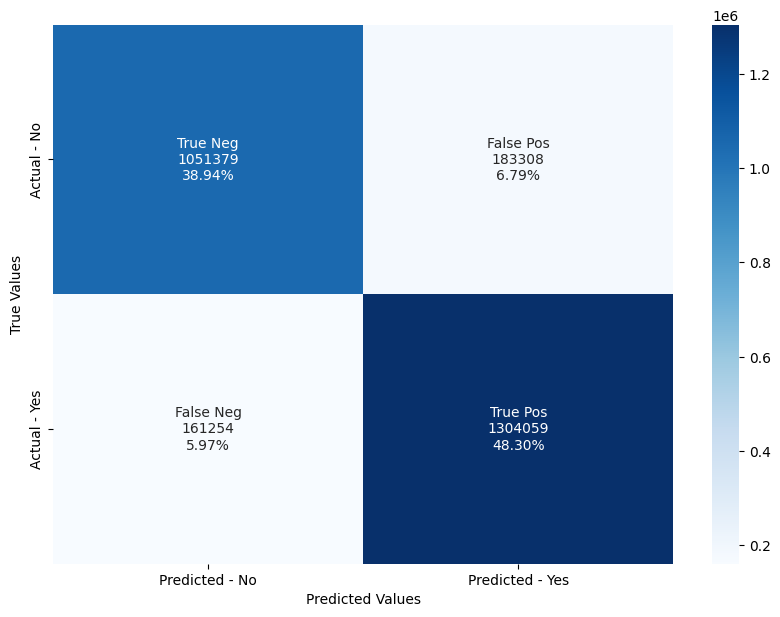

In [16]:
make_confusion_matrix(
    model=xgbclass_tuned,
    x=x_test,
    y=outcome_test
)

In [17]:
get_model_scores(
    model=xgbclass_tuned,
    x=x_train,
    y=outcome_train,
    title='xgb_tuned_train'
)

,Title,Accuracy,Recall,Precision,F1 Score
0,xgb_tuned_train,0.872573,0.890435,0.876699,0.883514


In [18]:
get_model_scores(
    model=xgbclass_tuned,
    x=x_test,
    y=outcome_test,
    title='xgb_tuned_test'
)

,Title,Accuracy,Recall,Precision,F1 Score
0,xgb_tuned_test,0.872384,0.889953,0.876757,0.883305


In [20]:
atk_str = 5
def_str = 5
prediction = xgbclass_tuned.predict_proba(
        pd.DataFrame(
        {
            #'const': 1.0,
            'atk_strength': atk_str,
            'def_strength': def_str
        },
        index=[0]
    )
)
prediction

array([[0.5019611 , 0.49803886]], dtype=float32)